Libraries

In [1]:
!pip install linformer
!pip install vit_pytorch
!pip install transformers
!pip install vit_keras
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 870.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.1 MB/s eta 0:00:00


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from torchvision.transforms import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch
#
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit
import tensorflow as tf

import tensorflow_hub as hub
#  3
import torch.nn as nn
import torch.optim as optim
from linformer import Linformer
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score

import torchvision
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


# Warnings
import warnings


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("CUDA-enabled PyTorch: ", torch.cuda.is_available())

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Num GPUs Available:  0
CUDA-enabled PyTorch:  False


In [3]:
# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

Hyperparameter

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
# Hyperparameters:
batch_size = 32
num_epochs = 10
lr = 3e-5
gamma = 0.7
seed = 142
IMG_SIZE = 128
patch_size = 16
num_classes = 2

Tensor Transforms & Data Loaders

In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

#train and test data directory
train_data_dir = "/content/drive/MyDrive/Colab Notebooks/images/training"
test_data_dir = "/content/drive/MyDrive/Colab Notebooks/images/testing"

Mounted at /content/drive


In [6]:
# Tensor Transforms (with Augmentation) and Pytorch Preprocessing:
#load the train and test data
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_ds = ImageFolder(train_data_dir,transform=transform)
test_ds = ImageFolder(test_data_dir,transform=transform)

img, label = train_ds[0]
print(img.shape,label)

torch.Size([3, 128, 128]) 0


In [7]:
# Data Loaders:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

Model Building

In [8]:
# Training device:
device = 'cpu'

# Linear Transformer:
efficient_transformer = Linformer(dim=128, seq_len=64+1, depth=12, heads=8, k=64)

# Vision Transformer Model:
model = ViT(dim=128, image_size=224, patch_size=patch_size, num_classes=num_classes, transformer=efficient_transformer, channels=3).to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Learning Rate Scheduler for Optimizer:
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

Model Training

In [9]:
# Training
epoch_losses = []
test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        #forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

         #Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #train loss  for the epochs
    epoch_loss = loss / len(train_loader)
    epoch_losses.append(epoch_loss)

    #Evaluate the model
    model.eval()
    test_accuracy = 0.0
    test_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            val_output = model(images)
            val_loss = criterion(val_output, labels)
            test_loss += val_loss.item()
            _, predicted = val_output.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    #Average test loss, accuracy, precision, and recall
    test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)

   #Metrics for plotting
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_precisions.append(precision)
    test_recalls.append(recall)



    print(f"Epoch [{epoch+1}/{num_epochs}] | Train loss : {epoch_loss:.4f} | Test_loss : {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/10] | Train loss : 0.0088 | Test_loss : 0.6621 | Test Accuracy: 61.81%
Epoch [2/10] | Train loss : 0.0062 | Test_loss : 0.6454 | Test Accuracy: 62.14%
Epoch [3/10] | Train loss : 0.0019 | Test_loss : 0.2250 | Test Accuracy: 90.28%
Epoch [4/10] | Train loss : 0.0015 | Test_loss : 0.1430 | Test Accuracy: 95.64%
Epoch [5/10] | Train loss : 0.0008 | Test_loss : 0.1189 | Test Accuracy: 96.65%
Epoch [6/10] | Train loss : 0.0000 | Test_loss : 0.1201 | Test Accuracy: 96.48%
Epoch [7/10] | Train loss : 0.0002 | Test_loss : 0.1027 | Test Accuracy: 97.65%
Epoch [8/10] | Train loss : 0.0000 | Test_loss : 0.1094 | Test Accuracy: 97.82%
Epoch [9/10] | Train loss : 0.0000 | Test_loss : 0.0623 | Test Accuracy: 98.16%
Epoch [10/10] | Train loss : 0.0000 | Test_loss : 0.1069 | Test Accuracy: 97.82%


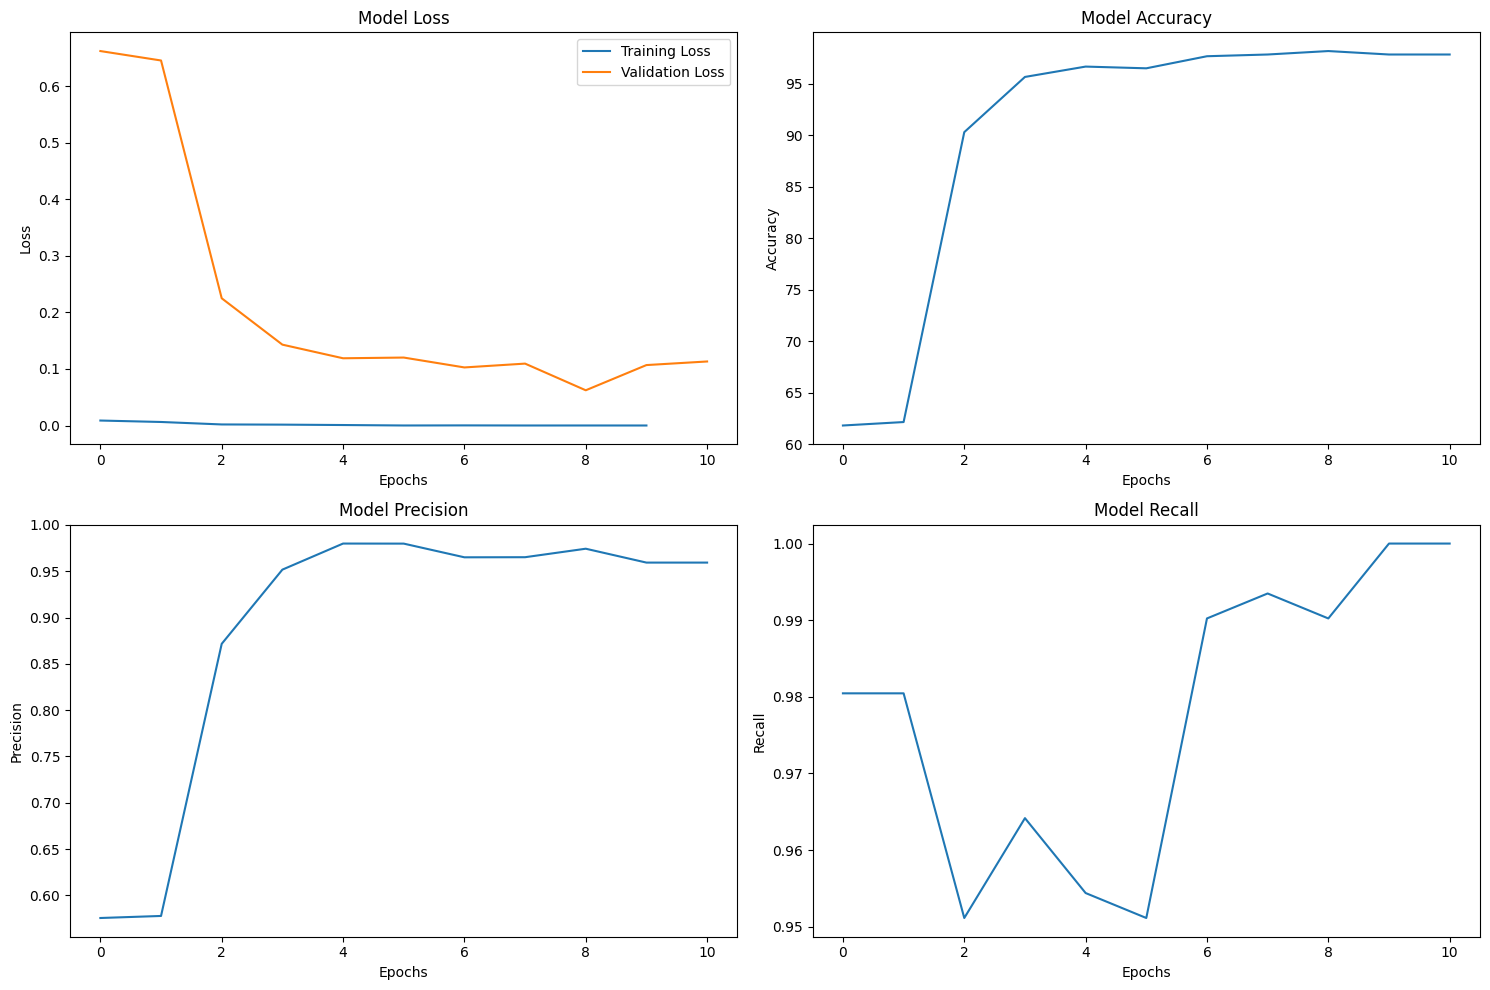

In [18]:
# Plotting
plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(torch.tensor(epoch_losses).detach().numpy(), label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(test_accuracies)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Precision
plt.subplot(2, 2, 3)
plt.plot(test_precisions)
plt.title('Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')

# Recall
plt.subplot(2, 2, 4)
plt.plot(test_recalls)
plt.title('Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

Model Saving

In [19]:
# Save Model:
PATH = "epochs"+"_"+str(num_epochs)+"_"+"img"+"_"+str(IMG_SIZE)+"_"+"patch"+"_"+str(patch_size)+"_"+"lr"+"_"+str(lr)+".pt"
torch.save(model.state_dict(), PATH)

In [20]:
# load saved model:
PATH = "epochs"+"_"+str(num_epochs)+"_"+"img"+"_"+str(IMG_SIZE)+"_"+"patch"+"_"+str(patch_size)+"_"+"lr"+"_"+str(lr)+".pt"
#efficient_transformer = Linformer(dim=128, seq_len=49+1, depth=12, heads=8, k=64)
#model = ViT(image_size=224, patch_size=32, num_classes=2, dim=128 ,transformer=efficient_transformer, channels=3)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Model Evaluation — Accuracy

In [21]:
# Performance on Valid/Test Data
def overall_accuracy(model, test_loader, criterion):

    '''
    Model testing

    Args:
        model: model used during training and validation
        test_loader: data loader object containing testing data
        criterion: loss function used

    Returns:
        test_loss: calculated loss during testing
        accuracy: calculated accuracy during testing
        y_proba: predicted class probabilities
        y_truth: ground truth of testing data
    '''

    y_proba = []
    y_truth = []
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(test_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        test_loss += criterion(output, y.long()).item()
        for index, i in enumerate(output):
            y_proba.append(i[1])
            y_truth.append(y[index])
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1

    accuracy = correct/total

    y_proba_out = np.array([float(y_proba[i]) for i in range(len(y_proba))])
    y_truth_out = np.array([float(y_truth[i]) for i in range(len(y_truth))])

    return test_loss, accuracy, y_proba_out, y_truth_out


loss, acc, y_proba, y_truth = overall_accuracy(model, test_loader, criterion = nn.CrossEntropyLoss())


print(f"Accuracy: {acc}")

print(pd.value_counts(y_truth))

  0%|          | 0/19 [00:00<?, ?it/s]

Accuracy: 0.9782244556113903
1.0    307
0.0    290
dtype: int64


The model correctly predicted 307 images class 1 and 209 images of class 0

Model Evaluation — ROC Curve

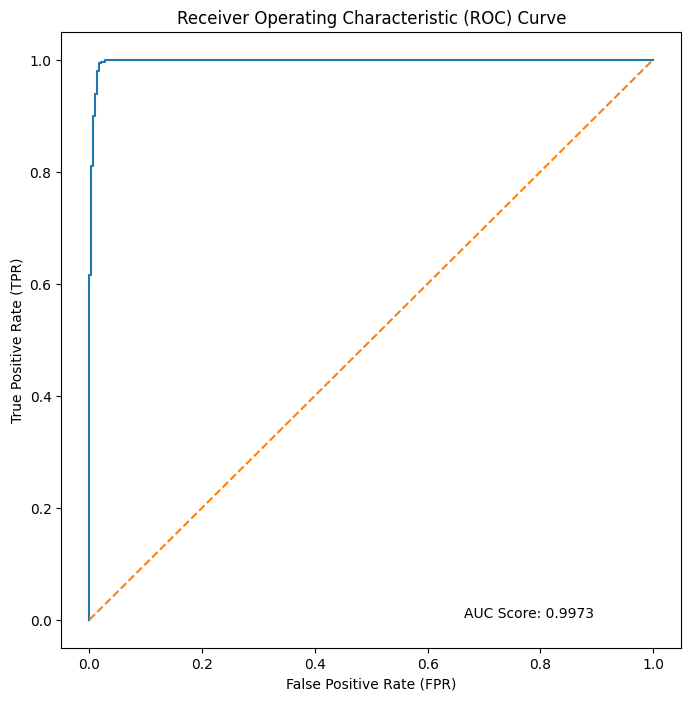

In [22]:
# Plot ROC curve:

def plot_ROCAUC_curve(y_truth, y_proba, fig_size):

    '''
    Plots the Receiver Operating Characteristic Curve (ROC) and displays Area Under the Curve (AUC) score.

    Args:
        y_truth: ground truth for testing data output
        y_proba: class probabilties predicted from model
        fig_size: size of the output pyplot figure

    Returns: void
    '''

    fpr, tpr, threshold = roc_curve(y_truth, y_proba)
    auc_score = roc_auc_score(y_truth, y_proba)
    txt_box = "AUC Score: " + str(round(auc_score, 4))
    plt.figure(figsize=fig_size)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'--')
    plt.annotate(txt_box, xy=(0.65, 0.05), xycoords='axes fraction')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
#     plt.savefig('ROC.png')
plot_ROCAUC_curve(y_truth, y_proba, (8, 8))


Model Evaluation Confusion Matrix

<Axes: >

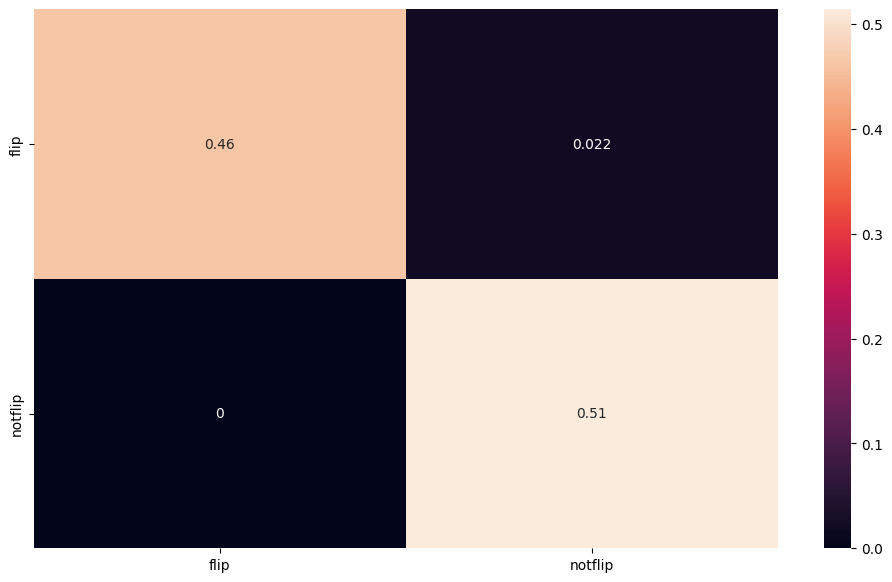

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []


# iterate over test data
for images, labels in test_loader:
        output = model(images) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('flip', 'notflip')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
# plt.savefig('cm.png')

Model Inference on New Images

predicted flip tensor: tensor([[ 3.9194, -3.7475]], grad_fn=<AddmmBackward0>)
predicted notflip tensor: tensor([[ 2.9134, -2.1709]], grad_fn=<AddmmBackward0>)

smoke


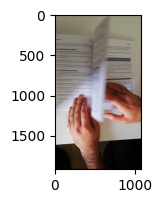

flip


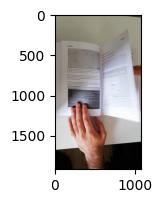

In [27]:
# Inference on Single Images (flip-notflip):
test_image = "/content/drive/MyDrive/Colab Notebooks/images/testing/flip/0001_000000020.jpg"
test_image_null = "/content/drive/MyDrive/Colab Notebooks/images/testing/flip/0002_000000012.jpg"
image = Image.open(test_image)
image_null = Image.open(test_image_null)

image.show()

# Define tensor transform and apply it:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
image_t = transform(image).unsqueeze(0)
image_null_t = transform(image_null).unsqueeze(0)

# Labels:
for images, labels in test_loader:
        labels = labels.data.cpu().numpy()

# Prediction:
out_flip = model(image_t)
out_notflip= model(image_null_t)
print("predicted flip tensor:", out_flip)
print("predicted notflip tensor:", out_notflip)
print("")
# Print:
if(labels[out_flip.argmax()]== 0):
    print("smoke")
else:
    print("else")

# Show Image:
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()
# Print:
if(labels[out_notflip.argmax()]== 0):
    print("flip")
else:
    print("notflip")

# Show Image Null:
plt.figure(figsize=(2, 2))
plt.imshow(image_null)
plt.show()